In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np # Don't use this other than for matplotlib
import copy

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

train_set = torchvision.datasets.FashionMNIST("./data", download=True,
                                              transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                           shuffle=True)


test_set = torchvision.datasets.FashionMNIST("./data", download=True, 
                                             train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False)

classes = ("T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")

In [74]:
torch.cuda.is_available()

False

Our image batch shape is torch.Size([4, 1, 28, 28])


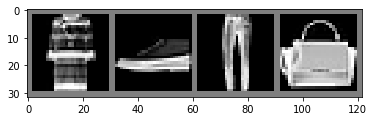

 Coat Ankle Boot Trouser   Bag


In [3]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
print("Our image batch shape is", images.size())
imshow(torchvision.utils.make_grid(images))

print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [4]:
import random

# Noise is added by removing one or two quadrants of the image
def noise(x):
    #temp = x
    for k in range(0,2):
        #print("Iteration ", k)
        x_offset = random.choice([0,14])
        y_offset = random.choice([0,14])
        #print("X: ", x_offset, " Y: ", y_offset)
        for i in range(x_offset, x_offset+14):
            for j in range(y_offset, y_offset+14):
                x[i][j] = 0
    return x
            
# Apply noise to all images
def apply_noise(trainxs):
    for i in range(0, len(trainxs)):
        trainxs[i] = noise(trainxs[i])
    return trainxs

In [5]:
# Test noise function
arr = [[1 for i in range(28)] for j in range(28)]
arr2 = [[1 for i in range(28)] for j in range(28)]
big = [arr, arr2]
apply_noise(big)
for x in big:
    print(np.matrix(x))

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 

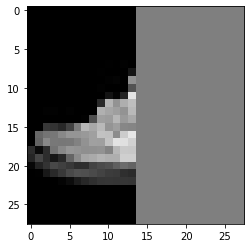

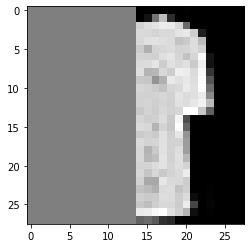

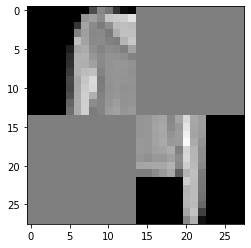

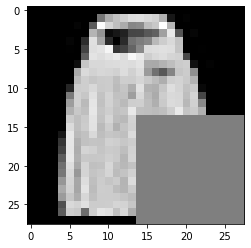

In [6]:
for data in train_loader:
    img, _ = data
    for i in range(0, len(img)):
        img[i][0] = noise(img[i][0])
        imshow(torchvision.utils.make_grid(img[i]))
    break

In [75]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [63]:
z_size = 32

class Autoencoder(nn.Module):
    def __init__(self, z_size):
        super(Autoencoder, self).__init__()
        self.z_size = z_size
        self.encoder = nn.Linear(28*28, z_size)
        self.decoder = nn.Linear(z_size, 28*28)
        
    def forward(self, input_x):
        encoded = torch.sigmoid(self.encoder(input_x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return decoded

In [76]:
autoencoder = Autoencoder(z_size)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

device = get_device()
print(device)
autoencoder.to(device)

cpu


Autoencoder(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)

In [72]:
def train(train_loader):
    epochs = 20
    
    for epoch in range(epochs):
        train_loss = 0.0
        
        for data in train_loader:
            imgs, _ = data
            noisy_imgs = copy.deepcopy(imgs)
            
            for i in range(0, len(imgs)):
                noisy_imgs[i][0] = noise(imgs[i][0])
                
            imgs = imgs.view(imgs.size(0), -1)
            noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), -1)
            
            optimizer.zero_grad()
            output = autoencoder(noisy_imgs)
            loss_func = mse_loss(output, imgs)
            loss_func.backward()
            optimizer.step()
            train_loss += loss_func.item()*imgs.size(0)
        
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))

In [73]:
train(train_loader)

Epoch: 0 	Training Loss: 1.430167
Epoch: 1 	Training Loss: 1.400324
Epoch: 2 	Training Loss: 1.385661
Epoch: 3 	Training Loss: 1.378387
Epoch: 4 	Training Loss: 1.372166


KeyboardInterrupt: 

In [ ]:
test_iter = iter(test_loader)
test_imgs, _ = test_iter.next()
test_noisy_imgs = copy.deepcopy(test_imgs)
for i in range(0, len(test_imgs)):
    test_noisy_imgs[i][0] = noise(test_imgs[i][0])
            
test_imgs = test_imgs.view(test_imgs.size(0), -1)
test_noisy_imgs = test_noisy_imgs.view(test_noisy_imgs.size(0), -1)

output = model(test_noisy_imgs)
test_noisy_imgs = test_noisy_imgs.numpy()
output = output.view(4, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for test_noisy_imgs, row in zip([test_noisy_imgs, output], axes):
    for img, ax in zip(test_noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)